# Stochastic NN on plane sums

In [1]:
import numpy as np
from matplotlib import pylab as plt

In [2]:
import src.operate_datasets    as operate_datasets
import src.model_visualisation as model_visualisation
import src.model_evaluation    as model_evaluation

Welcome to JupyROOT 6.18/00


## Load data

In [3]:
full_X, full_y = operate_datasets.load_dataset('~/snd_data/new_dataset/', 'longitudal')

X_train, y_train, _, _ = operate_datasets.split_dataset(full_X, full_y)

In [4]:
X_train.shape

(108000, 13)

In [5]:
#X_train = X_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)

In [6]:
#min_clip = 500
#X_train_clp, y_train_clp = operate_datasets.clip_dataset(X_train, y_train, min_clip)
X_train_clp, y_train_clp = X_train, y_train

## Fit model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import constraints
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

In [8]:
X_tens = torch.tensor(X_train_clp).float()
y_tens = torch.tensor(y_train_clp).float()

In [9]:
X_tens.shape

torch.Size([108000, 13])

In [107]:
class BNN(PyroModule):
    def __init__(self, inp_dim, hid_dim):
        super().__init__()
        
        self.fc1 = PyroModule[nn.Linear](inp_dim, hid_dim)
        self.fc2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.fc3 = PyroModule[nn.Linear](hid_dim, 1)

        # register random values that Pyro will work with
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, inp_dim]).to_event(2))
        self.fc1.bias   = PyroSample(dist.Normal(0., 1.).expand([hid_dim]).to_event(1))

        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, hid_dim]).to_event(2))
        self.fc2.bias   = PyroSample(dist.Normal(0., 1.).expand([hid_dim]).to_event(1))

        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, hid_dim]).to_event(2))
        self.fc3.bias   = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        return       


    def forward(self, x, y):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        mu = self.fc3(x).squeeze()

        # Pyro's sampling
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y.squeeze())
        
        return mu

In [108]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [126]:
def run_training(num_iter):
    model = BNN(X_tens[0].shape[0], 8)    
    guide = AutoDiagonalNormal(model) 

    predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("obs", "_RETURN"))
    
    #adam = pyro.optim.Adam({'lr' : 1e-1})
    adam = pyro.optim.ReduceLROnPlateau({'optimizer'  : torch.optim.Adam, 
                                         'optim_args' : {'lr' : 1e-1},
                                         'patience'   : 1,
                                         'verbose'    : True,
                                         'factor'     : 0.1})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    
    pyro.clear_param_store()

    loss_arr = []

    for j in range(num_iter):
        running_loss = 0

        loss = svi.step(X_tens, y_tens)
        running_loss += loss

        loss_arr.append(running_loss)

        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f lr %g" % (j + 1, loss, 123))

    return model, loss_arr, predictive

In [127]:
# get predictions on the full dataset for analysis

from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std":  torch.std(v, 0),
            "5%":   v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%":  v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [128]:
model, loss_arr, predictive = run_training(1000)

[iteration 0050] loss: 248423.4740 lr 123
[iteration 0100] loss: 268733.0941 lr 123
[iteration 0150] loss: 60484.0062 lr 123
[iteration 0200] loss: 556724.8385 lr 123
[iteration 0250] loss: 95136.8908 lr 123
[iteration 0300] loss: 115454.5609 lr 123
[iteration 0350] loss: 96063.0721 lr 123
[iteration 0400] loss: 208739.3823 lr 123
[iteration 0450] loss: 77974.9069 lr 123
[iteration 0500] loss: 97981.2519 lr 123
[iteration 0550] loss: 87478.5645 lr 123
[iteration 0600] loss: 93403.2037 lr 123
[iteration 0650] loss: 81338.4858 lr 123
[iteration 0700] loss: 113258.9218 lr 123
[iteration 0750] loss: 105341.9383 lr 123
[iteration 0800] loss: 141773.7749 lr 123
[iteration 0850] loss: 63896.6402 lr 123
[iteration 0900] loss: 63017.3904 lr 123
[iteration 0950] loss: 64653.9348 lr 123
[iteration 1000] loss: 79544.4394 lr 123


In [129]:
samples = predictive(X_tens, y_tens)
pred_summary = summary(samples)

In [130]:
y_pred = pred_summary['_RETURN']['mean'].detach().cpu().numpy()

In [131]:
y_pred

array([0.20516258, 0.18850239, 0.21744703, ..., 0.2007904 , 0.19380987,
       0.19722718], dtype=float32)

## Visualise results

In [132]:
X_sum = X_train.sum(axis=1).reshape(-1,1)

In [133]:
y_train = y_train.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [134]:
model_name = 'BNN on plane sums'
save_file_prefix = model_name.replace(' ', '-')

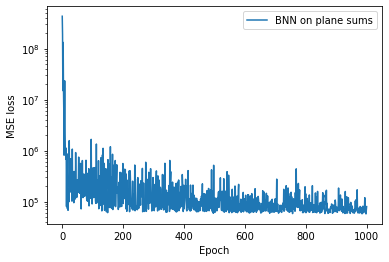

In [135]:
def plot_loss_arrays(loss_dict):
    for key in loss_dict.keys():
        plt.plot(loss_dict[key][0:], label=key)
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('MSE loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return
    
plot_loss_arrays({model_name : loss_arr})

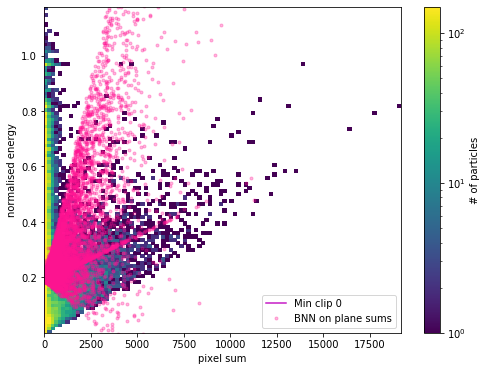

In [136]:
model_visualisation.plot_2d_energy_hist_clip(X_sum, y_train, y_pred, 0, model_name,
                                             save_file_prefix=save_file_prefix) 

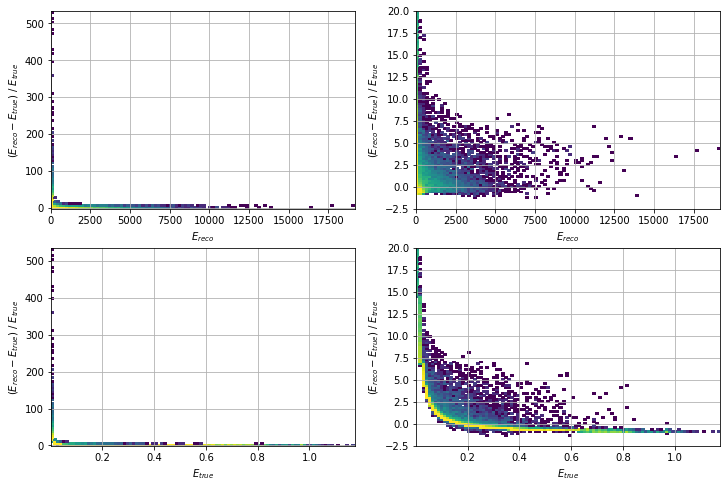

In [137]:
model_visualisation.plot_res_vs_energy(X_sum, y_train, y_pred, vmax=450,
                                       save_file_prefix=save_file_prefix) 

mean   = 2.05197e+00
std    = 7.80561e+00
median = 4.02158e-01


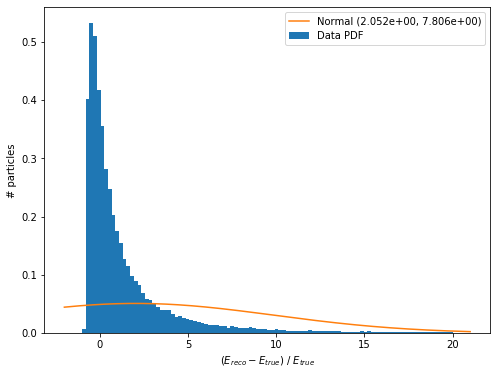

In [138]:
model_visualisation.plot_res_hist_fit(y_train, y_pred, [-1,20],
                                      save_file_prefix=save_file_prefix)

In [139]:
model_evaluation.save_scores(y_train, y_pred, save_file_prefix)

explained_variance_score -0.15582658464710097
max_error 3.594340206758474
mean_absolute_error 0.1389153046568893
mean_squared_error 0.0370298307508052
median_absolute_error 0.11500627565516003
r2_score -0.1574445371289266


,BNN-on-plane-sums
explained_variance_score,-0.155827
max_error,3.594340
mean_absolute_error,0.138915
mean_squared_error,0.037030
median_absolute_error,0.115006
r2_score,-0.157445
avg_resolution,2.051967
std_resolution,7.805608


In [140]:
model_evaluation.collect_all_scores()

,Score,BNN-on-plane-sums,L2-on-full-sum-(clipped-data),NN-on-projections,L2-on-projections,NN-on-sum,L2-on-plane-sums,NN-on-plane-sums,NN-on-full-sum,L2-on-true-hits,BNN-on-full-sum
0,explained_variance_score,-0.155827,0.014135,0.225436,0.050684,0.020719,0.279462,0.223457,0.075339,0.127250,-0.446316
1,max_error,3.594340,1.003849,1.001440,0.977129,1.044819,1.035705,3.286568,1.058454,0.999070,3.465975
2,mean_absolute_error,0.138915,0.130024,0.114736,0.129588,0.126946,0.113108,0.114574,0.128445,0.125568,0.156287
3,mean_squared_error,0.037030,0.032028,0.024449,0.029965,0.033186,0.023052,0.024844,0.029624,0.027922,0.054591
4,median_absolute_error,0.115006,0.104099,0.092253,0.110256,0.092175,0.092548,0.091460,0.103295,0.107848,0.098533
5,r2_score,-0.157445,-0.001109,0.225436,0.050683,-0.037294,0.279462,0.223457,0.074040,0.127250,-0.706345
6,avg_resolution,2.051967,1.729036,1.712018,2.009617,1.320563,1.498581,1.420332,1.714747,1.872374,0.650775
7,std_resolution,7.805608,7.130151,6.811143,7.685008,5.642022,5.833365,5.399274,5.726104,7.319886,5.922440
